In [1]:
import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import math
import heapq
import random

In [2]:
# ---------- Config (edit if your filenames differ) ----------
FILENAMES = {
    "domain":      "warehouse_domain_formal.rddl",
    "instance":    "warehouse_instance_6x6_formal.rddl",
    "nonfl_clear": "warehouse_nonfluents_6x6_clear_formal.rddl",
    "nonfl_shelf": "warehouse_nonfluents_6x6_shelves_formal.rddl",
}

RE = {
    "domain_decl": re.compile(r"\bdomain\s+([A-Za-z_][A-Za-z0-9_]*)\s*{", re.IGNORECASE),
    "instance_decl": re.compile(r"\binstance\s+([A-Za-z_][A-Za-z0-9_]*)\s*{", re.IGNORECASE),
    "nonfluent_decl": re.compile(r"\bnon-fluents\s+([A-Za-z_][A-Za-z0-9_]*)\s*{", re.IGNORECASE),

    "domain_ref": re.compile(r"\bdomain\s*=\s*([A-Za-z_][A-Za-z0-9_]*)\s*;", re.IGNORECASE),
    "nonfluent_ref": re.compile(r"\bnon-fluents\s*=\s*([A-Za-z_][A-Za-z0-9_]*)\s*;", re.IGNORECASE),

    "types_block": re.compile(r"\btypes\s*{([^}]*)}", re.IGNORECASE | re.DOTALL),
    "objects_block": re.compile(r"\bobjects\s*{([^}]*)}", re.IGNORECASE | re.DOTALL),

    "pvars_block": re.compile(r"\bpvariables\s*{", re.IGNORECASE),
    "cpfs_block": re.compile(r"\bcpfs\s*{", re.IGNORECASE),
    "reward_block": re.compile(r"\breward\s*=\s*(.*?);", re.IGNORECASE | re.DOTALL),

    "inits_block": re.compile(r"\binit-state\s*{([^}]*)}", re.IGNORECASE | re.DOTALL),

    "horizon": re.compile(r"\bhorizon\s*=\s*([0-9]+)\s*;", re.IGNORECASE),
    "discount": re.compile(r"\bdiscount\s*=\s*([0-9]*\.?[0-9]+)\s*;", re.IGNORECASE),
    "max_nondef_actions": re.compile(r"\bmax-nondef-actions\s*=\s*([0-9]+)\s*;", re.IGNORECASE),
}

In [3]:
# ---------- basic helpers ----------
def read_text(p: str) -> str:
    return Path(p).read_text(encoding="utf-8", errors="ignore")

def strip_comments(text: str) -> str:
    text = re.sub(r"//.*", "", text)                      # // line comments
    text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL) # /* block comments */
    return text

def parse_pairs(block: str):
    pairs = {}
    if not block:
        return pairs
    for line in re.split(r";|\n", block):
        if ":" in line:
            t, rest = line.split(":", 1)
            items = [x.strip() for x in re.split(r"[,\s]+", rest) if x.strip()]
            if items:
                pairs[t.strip()] = sorted(set(items))
    return pairs

def extract_pvariables_between(text_no_comments: str):
    """
    Extract pvariables between 'pvariables {' and 'cpfs {'.
    Supports:
      - NAME : { TYPE, state-fluent/action-fluent/... }
      - state fluent NAME(args) / action fluent NAME(args)
    """
    out = {"state": [], "action": [], "intermediate": [], "observable": [], "nonfluent": [], "others": []}
    m_start = RE["pvars_block"].search(text_no_comments)
    m_end = RE["cpfs_block"].search(text_no_comments)
    segment = text_no_comments[m_start.end():m_end.start()] if (m_start and m_end) else text_no_comments

    # Style 1
    for m in re.finditer(r"\b([A-Za-z_][A-Za-z0-9_]*)\s*:\s*{\s*[^,}]+,\s*([A-Za-z-]+)\s*}", segment):
        name = m.group(1)
        kind = m.group(2).lower()
        if "state-fluent" in kind:
            out["state"].append(name)
        elif "action-fluent" in kind:
            out["action"].append(name)
        elif "intermediate" in kind or "interm-fluent" in kind:
            out["intermediate"].append(name)
        elif "observ" in kind:
            out["observable"].append(name)
        elif "non-fluent" in kind or "nonfluent" in kind:
            out["nonfluent"].append(name)
        else:
            out["others"].append(name)

    # Style 2
    for m in re.finditer(r"\b(state|action|intermediate|observ|nonfluent)\b[^\n;]*?\b([A-Za-z_][A-Za-z0-9_]*)\s*\(", segment, re.IGNORECASE):
        kind = m.group(1).lower()
        name = m.group(2)
        if kind.startswith("observ"):
            kind = "observable"
        out.get(kind, out["others"]).append(name)

    for k in out:
        out[k] = sorted(set(out[k]))
    out["action"] = [n for n in out["action"] if n != "fluents"]
    return out

# ---------- Structured summaries ----------
def summarize_domain(text_raw: str):
    text = strip_comments(text_raw)
    info = {
        "kind": "domain",
        "domain_name": (RE["domain_decl"].search(text).group(1) if RE["domain_decl"].search(text) else None),
        "types": sorted(parse_pairs(RE["types_block"].search(text).group(1)).keys()) if RE["types_block"].search(text) else [],
        "objects": parse_pairs(RE["objects_block"].search(text).group(1)) if RE["objects_block"].search(text) else {},
        "pvariables": extract_pvariables_between(text) if (RE["pvars_block"].search(text) and RE["cpfs_block"].search(text)) else {},
        "has_reward": bool(RE["reward_block"].search(text)),
        "cpfs_count": 0
    }
    m_c = re.search(r"\bcpfs\s*{(.*?)}", text, flags=re.IGNORECASE | re.DOTALL)
    info["cpfs_count"] = len([s for s in re.split(r";", m_c.group(1)) if s.strip()]) if m_c else 0
    return info

def summarize_instance(text_raw: str):
    text = strip_comments(text_raw)
    info = {
        "kind": "instance",
        "instance_name": (RE["instance_decl"].search(text).group(1) if RE["instance_decl"].search(text) else None),
        "domain_ref": (RE["domain_ref"].search(text).group(1) if RE["domain_ref"].search(text) else None),
        "nonfluent_ref": (RE["nonfluent_ref"].search(text).group(1) if RE["nonfluent_ref"].search(text) else None),
        "horizon": int(RE["horizon"].search(text).group(1)) if RE["horizon"].search(text) else None,
        "discount": float(RE["discount"].search(text).group(1)) if RE["discount"].search(text) else None,
        "max_nondef_actions": int(RE["max_nondef_actions"].search(text).group(1)) if RE["max_nondef_actions"].search(text) else None,
        "objects": parse_pairs(RE["objects_block"].search(text).group(1)) if RE["objects_block"].search(text) else {},
        "init_assignments": [],
        "init_agent_xy": None
    }
    m_init = RE["inits_block"].search(text)
    if m_init:
        assigns = [s.strip() for s in re.split(r";", m_init.group(1)) if s.strip()]
        info["init_assignments"] = assigns
        # Try to extract agent start (agent_x, agent_y) if present
        ax = re.search(r"\bagent_x\s*=\s*([0-9]+)", m_init.group(1))
        ay = re.search(r"\bagent_y\s*=\s*([0-9]+)", m_init.group(1))
        if ax and ay:
            info["init_agent_xy"] = (int(ax.group(1)), int(ay.group(1)))
    return info

def summarize_nonfluents(text_raw: str):
    text = strip_comments(text_raw)
    name_m = RE["nonfluent_decl"].search(text)
    info = {
        "kind": "non-fluents",
        "nonfluent_name": (name_m.group(1) if name_m else None),
        "domain_ref": (RE["domain_ref"].search(text).group(1) if RE["domain_ref"].search(text) else None),
        "objects": parse_pairs(RE["objects_block"].search(text).group(1)) if RE["objects_block"].search(text) else {},
        "H": None, "W": None, "GOAL_X": None, "GOAL_Y": None,
        "obstacles": []
    }
    inner = re.search(r"\bnon-fluents\s*{(.*?)}", text, flags=re.IGNORECASE | re.DOTALL)
    body = inner.group(1) if inner else ""
    def grab_int(var):
        m = re.search(fr"\b{var}\s*=\s*([0-9]+)", body)
        return int(m.group(1)) if m else None
    info["H"] = grab_int("H")
    info["W"] = grab_int("W")
    info["GOAL_X"] = grab_int("GOAL_X")
    info["GOAL_Y"] = grab_int("GOAL_Y")
    coords = re.findall(r"OBSTACLE\s*\(\s*([0-9]+)\s*,\s*([0-9]+)\s*\)\s*=\s*true", body, flags=re.IGNORECASE)
    info["obstacles"] = [(int(a), int(b)) for a,b in coords]
    return info

def summarize_file(path: str):
    raw = read_text(path)
    if re.search(r"\bdomain\s+[A-Za-z_][A-Za-z0-9_]*\s*{", raw, re.IGNORECASE):   return ("domain", summarize_domain(raw))
    if re.search(r"\binstance\s+[A-Za-z_][A-Za-z0-9_]*\s*{", raw, re.IGNORECASE): return ("instance", summarize_instance(raw))
    if re.search(r"\bnon-fluents\s+[A-Za-z_][A-Za-z0-9_]*\s*{", raw, re.IGNORECASE): return ("nonfl", summarize_nonfluents(raw))
    return ("unknown", {"kind": "unknown"})

# ---------- Pretty printing ----------
def print_header(title):
    print("\n" + "="*80)
    print(title)
    print("="*80)

def pretty_domain(info: dict):
    print(f"Domain name: {info.get('domain_name')}")
    print(f"Types: {', '.join(info.get('types', [])) or '(none)'}")
    objs = info.get("objects") or {}
    if objs:
        print("Objects:")
        for t, items in objs.items():
            print(f"  - {t}: {', '.join(items)}")
    pv = info.get("pvariables", {})
    print(f"State fluents ({len(pv.get('state', []))}): {pv.get('state', []) or '(none)'}")
    print(f"Action fluents ({len(pv.get('action', []))}): {pv.get('action', []) or '(none)'}")
    print(f"Has reward: {info.get('has_reward')} | CPFs (rough count): {info.get('cpfs_count')}")

def pretty_instance(info: dict):
    print(f"Instance name: {info.get('instance_name')}")
    print(f"Domain ref: {info.get('domain_ref')}")
    print(f"Non-fluents ref: {info.get('nonfluent_ref')}")
    print(f"Horizon: {info.get('horizon')}  Discount: {info.get('discount')}  MaxNondefActions: {info.get('max_nondef_actions')}")
    objs = info.get("objects") or {}
    if objs:
        print("Objects:")
        for t, items in objs.items():
            print(f"  - {t}: {', '.join(items)}")
    inits = info.get("init_assignments", []) or []
    if inits:
        print("Init-state:")
        for a in inits:
            print(f"  - {a}")
    if info.get("init_agent_xy"):
        print(f"Parsed start (agent_x, agent_y): {info['init_agent_xy']}")

def pretty_nonfluents(info: dict, tag: str):
    print(f"Non-fluents name: {info.get('nonfluent_name')} ({tag})")
    print(f"Domain ref: {info.get('domain_ref')}")
    objs = info.get("objects") or {}
    if objs:
        print("Objects:")
        for t, items in objs.items():
            print(f"  - {t}: {', '.join(items)}")
    H, W = info.get("H"), info.get("W")
    gx, gy = info.get("GOAL_X"), info.get("GOAL_Y")
    print(f"H x W = {H} x {W} | Goal = ({gx}, {gy})")
    print(f"Obstacles: {len(info.get('obstacles', []))}")
    if info.get("obstacles", [])[:10]:
        print(f"Sample obstacles (first 10): {info['obstacles'][:10]}")

# State & action overview (ElevatorEnv-like)
def print_state_action_overview(dom_info: dict, nfl_info: dict, tag: str):
    print("\n" + "-"*80)
    print(f"[State & Action overview] Map = {tag}")
    pv = dom_info.get("pvariables", {})
    states = pv.get("state", [])
    actions = pv.get("action", [])
    # A) Vector view: state dim = number of state fluents
    print(f"- State (vector view): dim = {len(states)} | variables = {states or '(none)'}")
    # B) Grid aggregation view: feasible cells = H*W - obstacles
    H, W = nfl_info.get("H"), nfl_info.get("W")
    feas = None
    if isinstance(H, int) and isinstance(W, int):
        feas = H*W - len(nfl_info.get("obstacles", []))
    print(f"- State (grid view): H={H}, W={W}, obstacles={len(nfl_info.get('obstacles', []))} -> feasible cells = {feas}")
    # Actions
    print(f"- Actions: count = {len(actions)} | set = {actions or '(none)'}")
    # Notes
    print(f"- Notes: typical dynamics = move_* tries to change (agent_x, agent_y); boundary/obstacle -> stay put.")
    print(f"         instance enforces max-nondef-actions=1 per step.")
    if dom_info.get("has_reward"):
        print(f"         reward shaping typical: step penalty; +/− for distance change; collision penalty; goal bonus.")


In [4]:
# ---------- Run on your files ----------
kind_dom, dom = summarize_file(FILENAMES["domain"])
kind_inst, inst = summarize_file(FILENAMES["instance"])
kind_clr, nfl_clear = summarize_file(FILENAMES["nonfl_clear"])
kind_shf, nfl_shelf = summarize_file(FILENAMES["nonfl_shelf"])

print("="*80); print("[Domain]"); print("="*80)
pretty_domain(dom)

print("\n" + "="*80); print("[Instance]"); print("="*80)
pretty_instance(inst)

print("\n" + "="*80); print("[Non-fluents] CLEAR"); print("="*80)
pretty_nonfluents(nfl_clear, "CLEAR")

print("\n" + "="*80); print("[Non-fluents] SHELVES"); print("="*80)
pretty_nonfluents(nfl_shelf, "SHELVES")


print_state_action_overview(dom, nfl_clear, "CLEAR")
print_state_action_overview(dom, nfl_shelf, "SHELVES")


[Domain]
Domain name: warehouse_grid_mdp
Types: pos
State fluents (2): ['agent_x', 'agent_y']
Action fluents (4): ['move_east', 'move_north', 'move_south', 'move_west']
Has reward: True | CPFs (rough count): 2

[Instance]
Instance name: warehouse_inst_6x6
Domain ref: warehouse_grid_mdp
Non-fluents ref: warehouse_6x6_shelves
Horizon: 200  Discount: 1.0  MaxNondefActions: 1
Init-state:
  - agent_x = 0
  - agent_y = 0
Parsed start (agent_x, agent_y): (0, 0)

[Non-fluents] CLEAR
Non-fluents name: warehouse_6x6_clear (CLEAR)
Domain ref: warehouse_grid_mdp
Objects:
  - pos: {0..5
H x W = 6 x 6 | Goal = (5, 5)
Obstacles: 0

[Non-fluents] SHELVES
Non-fluents name: warehouse_6x6_shelves (SHELVES)
Domain ref: warehouse_grid_mdp
Objects:
  - pos: {0..5
H x W = 6 x 6 | Goal = (5, 5)
Obstacles: 12
Sample obstacles (first 10): [(1, 0), (1, 1), (1, 3), (1, 4), (2, 4), (3, 1), (3, 2), (3, 4), (5, 1), (5, 2)]

--------------------------------------------------------------------------------
[State & Act

Start (from instance): (0, 0)
Goal (from non-fluents CLEAR): (5, 5)
Goal (from non-fluents SHELVES): (5, 5)


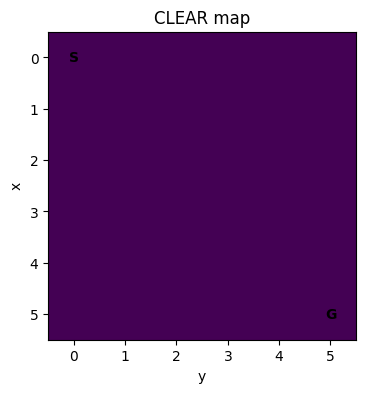

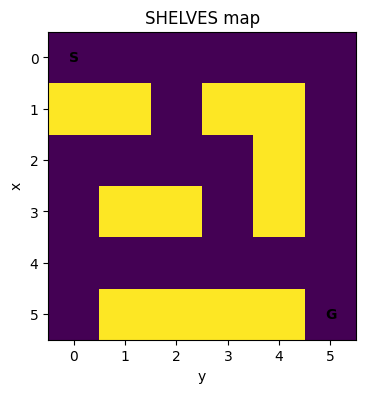

In [5]:
# =========================================
# Cell 1: Grid building + basic visualization
# =========================================

def build_grid(nonfl: dict):
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = [[0]*W for _ in range(H)]
    for (x, y) in nonfl.get("obstacles", []):
        if 0 <= x < H and 0 <= y < W:
            grid[x][y] = 1
    return grid

def plot_grid(nonfl: dict, start_xy=None, title="map"):
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = build_grid(nonfl)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(grid)  # default colormap
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

    if start_xy:
        sx, sy = start_xy
        if 0 <= sx < H and 0 <= sy < W:
            ax.text(sy, sx, "S", ha="center", va="center", fontweight="bold")
    gx, gy = nonfl.get("GOAL_X"), nonfl.get("GOAL_Y")
    if isinstance(gx, int) and isinstance(gy, int):
        ax.text(gy, gx, "G", ha="center", va="center", fontweight="bold")

    plt.show()

start_xy = inst.get("init_agent_xy")
print("Start (from instance):", start_xy)
print("Goal (from non-fluents CLEAR):", (nfl_clear.get("GOAL_X"), nfl_clear.get("GOAL_Y")))
print("Goal (from non-fluents SHELVES):", (nfl_shelf.get("GOAL_X"), nfl_shelf.get("GOAL_Y")))

plot_grid(nfl_clear, start_xy, title="CLEAR map")
plot_grid(nfl_shelf, start_xy, title="SHELVES map")


Single-agent (CLEAR) start/goal: (0, 0) (5, 5)
Path length: 10
Actions: ['E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']


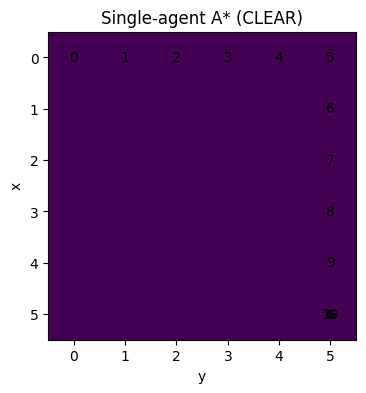

In [6]:
# =========================================
# Cell 2: Single-agent A* + path->actions
# =========================================

Action = Tuple[int, int, str]
ACTIONS: List[Action] = [
    (-1,  0, "N"),  # up
    ( 1,  0, "S"),  # down
    ( 0,  1, "E"),  # right
    ( 0, -1, "W"),  # left
]

def in_bounds(H, W, x, y):
    return 0 <= x < H and 0 <= y < W

def neighbors(grid, x, y):
    H, W = len(grid), len(grid[0])
    for dx, dy, a in ACTIONS:
        nx, ny = x + dx, y + dy
        if in_bounds(H, W, nx, ny) and grid[nx][ny] == 0:
            yield nx, ny, a
    # If blocked (all around), you could allow "wait" in single-agent as well if needed.

def manhattan(a: Tuple[int,int], b: Tuple[int,int]) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def astar(grid, start: Tuple[int,int], goal: Tuple[int,int]) -> Optional[List[Tuple[int,int]]]:
    H, W = len(grid), len(grid[0])
    if not (in_bounds(H, W, start[0], start[1]) and in_bounds(H, W, goal[0], goal[1])):
        return None
    if grid[start[0]][start[1]] == 1 or grid[goal[0]][goal[1]] == 1:
        return None

    openpq = []
    heapq.heappush(openpq, (manhattan(start, goal), 0, start))
    came = {start: None}
    g = {start: 0}

    while openpq:
        f, _, cur = heapq.heappop(openpq)
        if cur == goal:
            # reconstruct
            path = []
            x = cur
            while x is not None:
                path.append(x)
                x = came[x]
            return list(reversed(path))
        cx, cy = cur
        for nx, ny, _ in neighbors(grid, cx, cy):
            ng = g[cur] + 1
            if (nx,ny) not in g or ng < g[(nx,ny)]:
                g[(nx,ny)] = ng
                came[(nx,ny)] = cur
                heapq.heappush(openpq, (ng + manhattan((nx,ny), goal), ng, (nx,ny)))
    return None

def path_to_actions(path: List[Tuple[int,int]]) -> List[str]:
    if not path or len(path) < 2:
        return []
    actions = []
    for (x1, y1), (x2, y2) in zip(path, path[1:]):
        dx, dy = x2 - x1, y2 - y1
        if   (dx, dy) == (-1, 0): actions.append("N")
        elif (dx, dy) == ( 1, 0): actions.append("S")
        elif (dx, dy) == ( 0, 1): actions.append("E")
        elif (dx, dy) == ( 0,-1): actions.append("W")
        else: actions.append("WAIT")  # fallback
    return actions

def plot_path(nonfl: dict, path: List[Tuple[int,int]], title="path"):
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = build_grid(nonfl)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(grid)
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)
    # draw path as step numbers
    if path:
        for t, (x,y) in enumerate(path):
            ax.text(y, x, str(t), ha="center", va="center")
    # mark goal
    gx, gy = nonfl.get("GOAL_X"), nonfl.get("GOAL_Y")
    if isinstance(gx, int) and isinstance(gy, int):
        ax.text(gy, gx, "G", ha="center", va="center", fontweight="bold")
    plt.show()

# ---- demo single-agent on CLEAR ----
grid_clear = build_grid(nfl_clear)
s = inst.get("init_agent_xy") or (0,0)
g = (nfl_clear.get("GOAL_X"), nfl_clear.get("GOAL_Y"))
print("Single-agent (CLEAR) start/goal:", s, g)
path = astar(grid_clear, s, g)
print("Path length:", None if path is None else len(path)-1)
print("Actions:", None if path is None else path_to_actions(path))
plot_path(nfl_clear, path, title="Single-agent A* (CLEAR)")


Starts: [(0, 5), (4, 2), (5, 0)]
Goals: [(5, 5), (1, 5), (3, 3)]
Plan lengths: [5, 8, 5]


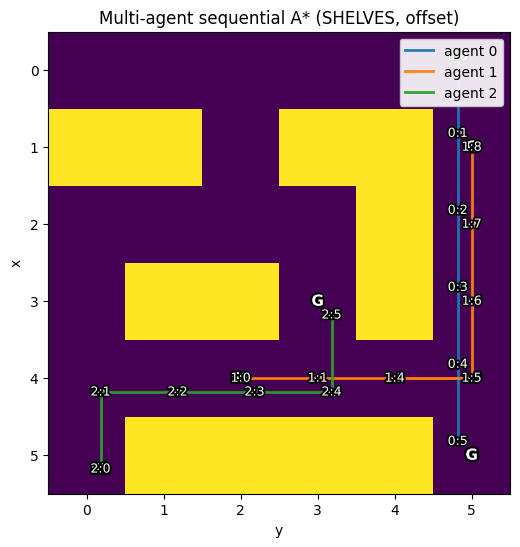

In [7]:
# ====================================================
# Cell 3: Multi-agent planning (time-expanded A* + priority planning)
# ====================================================
# Conflicts:
#  - vertex conflict: same (x,y) at same t
#  - edge conflict: (x1,y1)->(x2,y2) while other agent goes (x2,y2)->(x1,y1) at same timestep
#
# We implement a time-aware A* where state = (x, y, t) and we allow actions: N,S,E,W,WAIT.
# Previously planned agents "reserve" cells and edges in occupied tables.

import matplotlib.patheffects as pe
from itertools import cycle

ALL_MOVES = [(-1,0,"N"),(1,0,"S"),(0,1,"E"),(0,-1,"W"),(0,0,"WAIT")]

def astar_time_aware(grid, start_xy, goal_xy, occupied_vertices, occupied_edges, t_start=0, t_max=512):
    H, W = len(grid), len(grid[0])
    sx, sy = start_xy
    gx, gy = goal_xy

    def h(n):
        (x, y, t) = n
        return manhattan((x,y), (gx,gy))

    start = (sx, sy, t_start)
    openpq = []
    heapq.heappush(openpq, (h(start), 0, start))
    g = {start: 0}
    came = {start: None}

    def is_free_vertex(x,y,t):
        # grid free + not reserved at time t
        if not in_bounds(H,W,x,y) or grid[x][y] == 1:
            return False
        return (t not in occupied_vertices) or ((x,y) not in occupied_vertices[t])

    def is_free_edge(x1,y1,x2,y2,t):
        # edge (t -> t+1) must not be reserved and no opposite traversal at same time
        pair = ((x1,y1),(x2,y2))
        if t in occupied_edges and pair in occupied_edges[t]:
            return False
        # opposite edge also blocked
        opp = ((x2,y2),(x1,y1))
        if t in occupied_edges and opp in occupied_edges[t]:
            return False
        return True

    while openpq:
        f, _, cur = heapq.heappop(openpq)
        x, y, t = cur
        if (x,y) == (gx,gy):
            # reconstruct (time-aware)
            seq = []
            node = cur
            while node is not None:
                seq.append(node)  # (x,y,t)
                node = came[node]
            seq = list(reversed(seq))
            # collapse to (x,y) sequence per step
            path_xy = [(xx,yy) for (xx,yy,tt) in seq]
            return path_xy

        if t >= t_max:
            continue

        for dx, dy, a in ALL_MOVES:
            nx, ny, nt = x + dx, y + dy, t + 1
            # must be free vertex at next time
            if not is_free_vertex(nx, ny, nt):
                continue
            # must be free edge if actually moved
            if not (dx == 0 and dy == 0):  # not WAIT
                if not is_free_edge(x,y,nx,ny,t):
                    continue
            ng = g[cur] + 1
            nxt = (nx, ny, nt)
            if nxt not in g or ng < g[nxt]:
                g[nxt] = ng
                came[nxt] = cur
                heapq.heappush(openpq, (ng + h(nxt), ng, nxt))
    return None

def reserve_path(occupied_vertices, occupied_edges, path_xy):
    # path_xy is [(x0,y0),(x1,y1),...], time steps t=0..T
    # reserve vertices at each t, and edges for transitions t->t+1
    for t, (x,y) in enumerate(path_xy):
        occupied_vertices.setdefault(t, set()).add((x,y))
        if t+1 < len(path_xy):
            x2, y2 = path_xy[t+1]
            occupied_edges.setdefault(t, set()).add(((x,y),(x2,y2)))

def multi_agent_sequential(grid, starts: List[Tuple[int,int]], goals: List[Tuple[int,int]], t_max=512):
    occupied_vertices = {}
    occupied_edges = {}
    plans = []
    for idx, (s,g) in enumerate(zip(starts, goals)):
        path = astar_time_aware(grid, s, g, occupied_vertices, occupied_edges, t_start=0, t_max=t_max)
        if path is None:
            plans.append(None)
        else:
            reserve_path(occupied_vertices, occupied_edges, path)
            plans.append(path)
    return plans

def plot_multiple_paths_pretty_offset(
    nonfl: dict,
    paths: List[Optional[List[Tuple[int,int]]]],
    starts: Optional[List[Tuple[int,int]]] = None,
    goals: Optional[List[Tuple[int,int]]] = None,
    title: str = "Multi-agent plan (offset)"
):
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = build_grid(nonfl)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid)
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

    # fixed small offsets per agent (x=row, y=col); tuned to stay inside the cell
    base_offsets = [(-0.18, -0.18), (0.0, 0.0), (0.18, 0.18), (0.18, -0.18), (-0.18, 0.18)]
    def get_agent_offset(k: int):
        dx, dy = base_offsets[k % len(base_offsets)]
        return dx, dy

    def white_text(ax, y, x, s, **kw):
        kw.setdefault("fontsize", 10)
        kw.setdefault("color", "white")
        kw.setdefault("ha", "center")
        kw.setdefault("va", "center")
        txt = ax.text(y, x, s, **kw)
        txt.set_path_effects([pe.withStroke(linewidth=2.5, foreground="black")])
        return txt

    # map goal (from nonfl)
    gx, gy = nonfl.get("GOAL_X"), nonfl.get("GOAL_Y")
    if isinstance(gx, int) and isinstance(gy, int):
        white_text(ax, gy, gx, "G", fontsize=12, fontweight="bold")

    # per-agent starts/goals if provided
    if starts:
        for i, (sx, sy) in enumerate(starts):
            dx, dy = get_agent_offset(i)
            white_text(ax, sy + dy, sx + dx, f"S{i}", fontsize=10, fontweight="bold")
    if goals:
        for (gx2, gy2) in goals:
            white_text(ax, gy2, gx2, "G", fontsize=11, fontweight="bold")

    # draw each agent
    for k, path in enumerate(paths):
        if not path:
            continue
        dx, dy = get_agent_offset(k)

        xs = [x + dx for (x, y) in path]  # row + offset
        ys = [y + dy for (x, y) in path]  # col + offset

        # polyline + points
        ax.plot(ys, xs, linestyle="-", linewidth=2.0, alpha=0.95, label=f"agent {k}")
        ax.scatter(ys, xs, s=22, edgecolors="white", linewidths=0.8, zorder=3)

        # time labels (offset together with the agent)
        for t, (x, y) in enumerate(path):
            white_text(ax, y + dy, x + dx, f"{k}:{t}", fontsize=9)

    ax.legend(loc="upper right", framealpha=0.9)
    plt.show()


# ---- demo: build starts/goals automatically if not found ----
def free_cells(nonfl: dict) -> List[Tuple[int,int]]:
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = build_grid(nonfl)
    cells = []
    for x in range(H):
        for y in range(W):
            if grid[x][y] == 0:
                cells.append((x,y))
    return cells

def auto_pick_starts_goals(nonfl: dict, k=3, seed=42, avoid_goal=True) -> Tuple[List[Tuple[int,int]], List[Tuple[int,int]]]:
    cells = free_cells(nonfl)
    random.Random(seed).shuffle(cells)
    gx, gy = nonfl.get("GOAL_X"), nonfl.get("GOAL_Y")
    if avoid_goal and isinstance(gx,int) and isinstance(gy,int):
        cells = [(x,y) for (x,y) in cells if (x,y)!=(gx,gy)]
    starts = cells[:k]
    # goals: try to use the map's GOAL for agent 0, and other random goals for others
    goals = []
    for i in range(k):
        if i == 0 and isinstance(gx,int) and isinstance(gy,int):
            goals.append((gx,gy))
        else:
            goals.append(cells[k+i] if k+i < len(cells) else starts[i])
    return starts, goals

# ---- run on SHELVES map for multi-agent demo ----
grid_sh = build_grid(nfl_shelf)
starts, goals = auto_pick_starts_goals(nfl_shelf, k=3, seed=7)
print("Starts:", starts)
print("Goals:", goals)
plans = multi_agent_sequential(grid_sh, starts, goals, t_max=256)
print("Plan lengths:", [None if p is None else len(p)-1 for p in plans])
plot_multiple_paths_pretty_offset(
    nfl_shelf,
    plans,
    starts=starts,
    goals=goals,
    title="Multi-agent sequential A* (SHELVES, offset)"
)


/tmp/ipython-input-1637418095.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", framealpha=0.9)


Saved GIF to: multi_agent_playback.gif


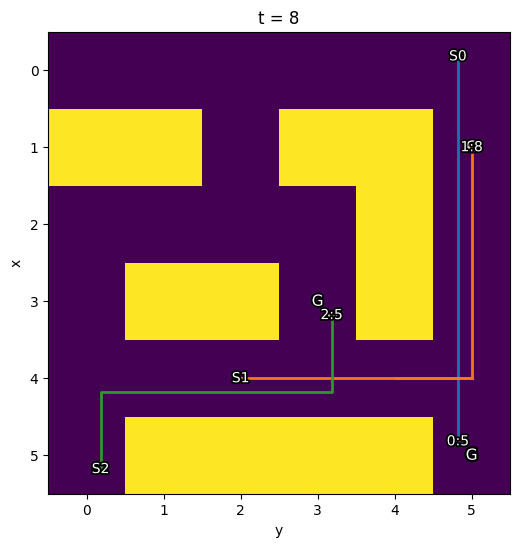

In [8]:
# GIF animation (no ffmpeg; uses PillowWriter)
from matplotlib.animation import PillowWriter
import numpy as np

def animate_paths_gif(
    nonfl: dict,
    paths: List[Optional[List[Tuple[int,int]]]],
    starts: Optional[List[Tuple[int,int]]] = None,
    goals: Optional[List[Tuple[int,int]]] = None,
    out_gif: str = "multi_agent_playback.gif",
    fps: int = 2
):
    H, W = nonfl.get("H"), nonfl.get("W")
    grid = build_grid(nonfl)

    # per-agent static offsets (reuse the same as static plot)
    base_offsets = [(-0.18, -0.18), (0.0, 0.0), (0.18, 0.18), (0.18, -0.18), (-0.18, 0.18)]
    def get_agent_offset(k: int):
        dx, dy = base_offsets[k % len(base_offsets)]
        return dx, dy

    # max time length
    T = 0
    for p in paths:
        if p:
            T = max(T, len(p)-1)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

    # draw static background once
    ax.imshow(grid)

    writer = PillowWriter(fps=fps)

    with writer.saving(fig, out_gif, dpi=120):
        for t in range(T+1):
            ax.clear()
            ax.imshow(grid)
            ax.set_title(f"t = {t}")
            ax.set_xticks(range(W)); ax.set_yticks(range(H))
            ax.set_xlabel("y"); ax.set_ylabel("x")
            ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

            # map goal (from nonfl)
            gx, gy = nonfl.get("GOAL_X"), nonfl.get("GOAL_Y")
            if isinstance(gx, int) and isinstance(gy, int):
                ax.text(gy, gx, "G", color="white", ha="center", va="center", fontsize=12,
                        path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])

            # per-agent starts/goals if given
            if starts:
                for i, (sx, sy) in enumerate(starts):
                    dx, dy = get_agent_offset(i)
                    ax.text(sy + dy, sx + dx, f"S{i}", color="white", ha="center", va="center", fontsize=10,
                            path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
            if goals:
                for (gx2, gy2) in goals:
                    ax.text(gy2, gx2, "G", color="white", ha="center", va="center", fontsize=11,
                            path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])

            # draw partial trajectories up to time t
            for k, p in enumerate(paths):
                if not p:
                    continue
                dx, dy = get_agent_offset(k)
                upto = min(t+1, len(p))

                xs = [x + dx for (x,y) in p[:upto]]
                ys = [y + dy for (x,y) in p[:upto]]

                # path so far
                if len(xs) >= 2:
                    ax.plot(ys, xs, linestyle="-", linewidth=2.0, alpha=0.95, label=f"agent {k}" if t == 0 else None)
                ax.scatter(ys[-1:], xs[-1:], s=28, edgecolors="white", linewidths=0.9, zorder=3)
                ax.text(ys[-1], xs[-1], f"{k}:{upto-1}", color="white", ha="center", va="center", fontsize=10,
                        path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])

            if t == 0:
                ax.legend(loc="upper right", framealpha=0.9)
            writer.grab_frame()

    print(f"Saved GIF to: {out_gif}")

animate_paths_gif(
    nonfl=nfl_shelf,
    paths=plans,
    starts=starts,
    goals=goals,
    out_gif="multi_agent_playback.gif",
    fps=2
)



In [9]:
# =========================================
# Cell 4: Evaluation helpers
# =========================================

def path_length(path: Optional[List[Tuple[int,int]]]) -> Optional[int]:
    if not path: return None
    return max(0, len(path)-1)

def success(path: Optional[List[Tuple[int,int]]], goal: Tuple[int,int]) -> bool:
    if not path: return False
    return path[-1] == goal

def count_vertex_conflicts(paths: List[Optional[List[Tuple[int,int]]]]) -> int:
    # Count time-synchronized vertex conflicts among provided paths
    tmax = 0
    for p in paths:
        if p:
            tmax = max(tmax, len(p)-1)
    conflicts = 0
    for t in range(tmax+1):
        seen = {}
        for i, p in enumerate(paths):
            if not p or t >= len(p):
                continue
            cell = p[t]
            seen.setdefault(cell, []).append(i)
        for cell, agents in seen.items():
            if len(agents) > 1:
                conflicts += (len(agents)-1)  # count extra occupancy
    return conflicts

def evaluate_multi_agent(grid, starts, goals, plans):
    lengths = [path_length(p) for p in plans]
    succs = [success(p, g) for p,g in zip(plans, goals)]
    v_conf = count_vertex_conflicts(plans)
    return {
        "avg_len": None if not lengths or any(l is None for l in lengths) else sum(lengths)/len(lengths),
        "success_rate": sum(succs)/len(succs),
        "vertex_conflicts": v_conf,
        "lengths": lengths,
        "successes": succs
    }

# ---- demo evaluation on shelves plan ----
report = evaluate_multi_agent(grid_sh, starts, goals, plans)
print(report)


{'avg_len': 6.0, 'success_rate': 1.0, 'vertex_conflicts': 0, 'lengths': [5, 8, 5], 'successes': [True, True, True]}


=== CLEAR map ===
[Single-agent]
start: (0, 0) goal: (5, 5) path_len: 10
actions: ['E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']


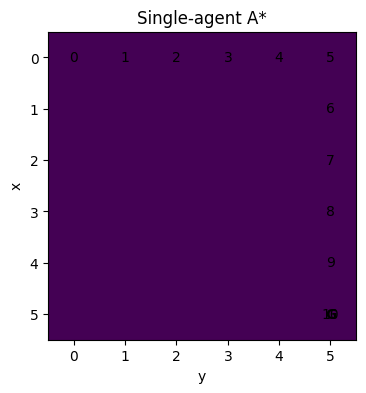

[Multi-agent]
starts: [(5, 0), (4, 2), (3, 3)]
goals: [(5, 5), (0, 3), (5, 2)]
lengths: [5, 5, 3]
success_rate: 1.0 vertex_conflicts: 0


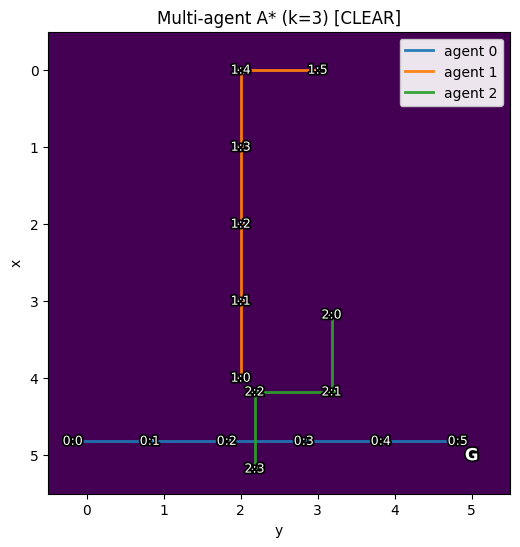


=== SHELVES map ===
[Single-agent]
start: (0, 0) goal: (5, 5) path_len: 10
actions: ['E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']


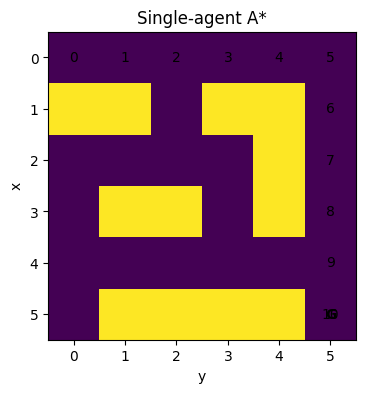

[Multi-agent]
starts: [(4, 1), (2, 5), (3, 3)]
goals: [(5, 5), (2, 2), (4, 0)]
lengths: [5, 7, 6]
success_rate: 1.0 vertex_conflicts: 0


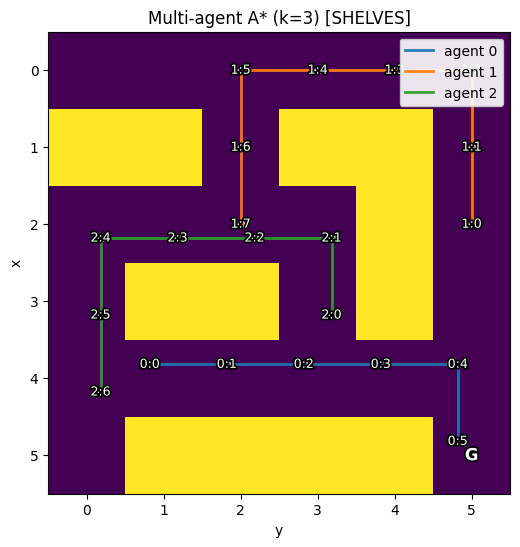


Summary:
CLEAR: {'avg_len': 4.333333333333333, 'success_rate': 1.0, 'vertex_conflicts': 0, 'lengths': [5, 5, 3], 'successes': [True, True, True]}
SHELVES: {'avg_len': 6.0, 'success_rate': 1.0, 'vertex_conflicts': 0, 'lengths': [5, 7, 6], 'successes': [True, True, True]}


In [10]:
# =========================================
# Cell 5: End-to-end demos on both maps
# =========================================

def single_agent_demo(nonfl: dict, inst: dict):
    grid = build_grid(nonfl)
    s = inst.get("init_agent_xy") or (0,0)
    g = (nonfl.get("GOAL_X"), nonfl.get("GOAL_Y"))
    path = astar(grid, s, g)
    acts = None if path is None else path_to_actions(path)
    print("[Single-agent]")
    print("start:", s, "goal:", g, "path_len:", None if path is None else len(path)-1)
    print("actions:", acts)
    plot_path(nonfl, path, title="Single-agent A*")

def multi_agent_demo(nonfl: dict, k=3, seed=11, title_suffix=""):
    grid = build_grid(nonfl)
    starts, goals = auto_pick_starts_goals(nonfl, k=k, seed=seed)
    plans = multi_agent_sequential(grid, starts, goals, t_max=256)
    metrics = evaluate_multi_agent(grid, starts, goals, plans)
    print("[Multi-agent]")
    print("starts:", starts)
    print("goals:", goals)
    print("lengths:", metrics["lengths"])
    print("success_rate:", metrics["success_rate"], "vertex_conflicts:", metrics["vertex_conflicts"])
    plot_multiple_paths_pretty_offset(nonfl, plans, title=f"Multi-agent A* (k={k}) {title_suffix}")
    return metrics

print("=== CLEAR map ===")
single_agent_demo(nfl_clear, inst)
m_clear = multi_agent_demo(nfl_clear, k=3, seed=13, title_suffix="[CLEAR]")

print("\n=== SHELVES map ===")
single_agent_demo(nfl_shelf, inst)
m_shelf = multi_agent_demo(nfl_shelf, k=3, seed=13, title_suffix="[SHELVES]")

print("\nSummary:")
print("CLEAR:", m_clear)
print("SHELVES:", m_shelf)


In [16]:
# ===== New RDDL files (pick&place 15x10) =====
NEW_FILES = {
    "domain":   "warehouse_pickplace_domain.rddl",
    "nonfl":    "warehouse_pickplace_nonfluents_15x10.rddl",
    "instance": "warehouse_pickplace_instance_15x10.rddl",
}

kind_d, dom2 = summarize_file(NEW_FILES["domain"])
kind_nf, nf2  = summarize_file(NEW_FILES["nonfl"])
kind_ins, ins2 = summarize_file(NEW_FILES["instance"])


print("="*80); print("[Domain]"); print("="*80)
pretty_domain(dom2)

print("\n" + "="*80); print("[Non-fluents]"); print("="*80)
pretty_nonfluents(nf2, "Pick&Place")

print("\n" + "="*80); print("[Instance]"); print("="*80)
pretty_instance(ins2)

print_state_action_overview(dom, nf2, "SHELVES")


[Domain]
Domain name: warehouse_pickplace
Types: pos
State fluents (4): ['agent_x', 'agent_y', 'carry', 'delivered']
Action fluents (4): ['move_east', 'move_north', 'move_south', 'move_west']
Has reward: True | CPFs (rough count): 4

[Non-fluents]
Non-fluents name: pp_nf_15x10_basic (Pick&Place)
Domain ref: warehouse_pickplace
Objects:
  - pos: {0..14
H x W = 15 x 10 | Goal = (None, None)
Obstacles: 12
Sample obstacles (first 10): [(1, 4), (1, 5), (4, 4), (5, 4), (6, 4), (8, 2), (8, 3), (8, 4), (8, 5), (10, 6)]

[Instance]
Instance name: pp_inst_15x10
Domain ref: warehouse_pickplace
Non-fluents ref: pp_nf_15x10_basic
Horizon: 400  Discount: 1.0  MaxNondefActions: 1
Init-state:
  - agent_x = 1
  - agent_y = 1
  - carry = false
  - delivered = false
Parsed start (agent_x, agent_y): (1, 1)

--------------------------------------------------------------------------------
[State & Action overview] Map = SHELVES
- State (vector view): dim = 2 | variables = ['agent_x', 'agent_y']
- State (gri

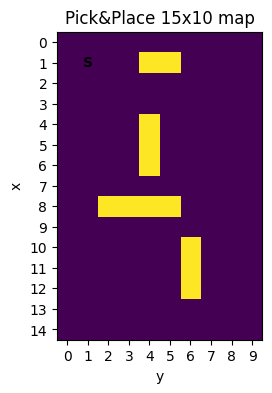

In [17]:
# ===== Visualize 15x10 map =====
start_xy2 = ins2.get("init_agent_xy") or (0,0)
plot_grid(nf2, start_xy=start_xy2, title="Pick&Place 15x10 map")

In [18]:
# ===============================
# Pick&Place inference utilities
# ===============================
import re
from pathlib import Path
from typing import List, Tuple, Optional

def read_text(path: str) -> str:
    return Path(path).read_text(encoding="utf-8", errors="ignore")

def parse_pick_drop_from_nonfluent_text(nf_text: str) -> Tuple[List[Tuple[int,int]], List[Tuple[int,int]]]:
    """Scan non-fluents for P(ick) and D(rop) cells via common predicate names."""
    picks, drops = [], []
    # Common aliases
    P_NAMES = ["PICK", "SOURCE", "ITEM_AT", "PICK_LOC", "PICKUP", "PICKUP_LOC"]
    D_NAMES = ["DROP", "TARGET", "DEST", "SINK", "PLACE", "DROP_LOC", "DELIVER_TO"]

    # helper
    def scan(name_list) -> List[Tuple[int,int]]:
        out = []
        for nm in name_list:
            for m in re.finditer(rf"\b{nm}\s*\(\s*([0-9]+)\s*,\s*([0-9]+)\s*\)\s*=\s*true\s*;", nf_text, re.IGNORECASE):
                out.append((int(m.group(1)), int(m.group(2))))
        # uniq
        seen=set(); uniq=[]
        for xy in out:
            if xy not in seen:
                uniq.append(xy); seen.add(xy)
        return uniq

    picks = scan(P_NAMES)
    drops = scan(D_NAMES)
    return picks, drops

def parse_start_from_instance_text(inst_text: str) -> Optional[Tuple[int,int]]:
    # try agent_x/agent_y, robot_x/robot_y
    for kx, ky in [("agent_x","agent_y"), ("robot_x","robot_y")]:
        mx = re.search(rf"\b{kx}\s*=\s*([0-9]+)\s*;", inst_text)
        my = re.search(rf"\b{ky}\s*=\s*([0-9]+)\s*;", inst_text)
        if mx and my:
            return (int(mx.group(1)), int(my.group(1)))
    return None

def first_free_cell_from_grid(nonfl: dict) -> Optional[Tuple[int,int]]:
    grid = build_grid(nonfl)
    H, W = nonfl["H"], nonfl["W"]
    for x in range(H):
        for y in range(W):
            if grid[x][y] == 0:
                return (x,y)
    return None

def validate_or_fallback(nonfl: dict, xy: Optional[Tuple[int,int]]) -> Optional[Tuple[int,int]]:
    if xy is None:
        return first_free_cell_from_grid(nonfl)
    H, W = nonfl["H"], nonfl["W"]
    x, y = xy
    if not (isinstance(x,int) and isinstance(y,int) and 0 <= x < H and 0 <= y < W):
        return first_free_cell_from_grid(nonfl)
    if build_grid(nonfl)[x][y] == 1:
        return first_free_cell_from_grid(nonfl)
    return xy


In [24]:
# ==========================================
# Two-phase plan: Start -> Pick -> Drop
# ==========================================

def plan_pick_and_drop(nonfl: dict,
                       start_xy: Tuple[int,int],
                       pick_xy: Tuple[int,int],
                       drop_xy: Tuple[int,int]):
    grid = build_grid(nonfl)
    p1 = astar(grid, start_xy, pick_xy)
    p2 = astar(grid, pick_xy, drop_xy)
    return p1, p2

def plot_pickdrop_offset(
    nonfl: dict,
    p1: Optional[List[Tuple[int,int]]],  # S -> P
    p2: Optional[List[Tuple[int,int]]],  # P -> D
    start_xy: Tuple[int,int],
    pick_xy: Tuple[int,int],
    drop_xy: Tuple[int,int],
    title: str = "Pick&Place S→P→D (offset)"
):
    H, W = nonfl["H"], nonfl["W"]
    grid = build_grid(nonfl)

    # phase offsets (row=x, col=y). Keep them small to stay inside the cell.
    off_p1 = (-0.18, -0.18)   # S->P
    off_p2 = ( 0.18,  0.18)   # P->D

    def wtxt(ax, y, x, s, **kw):
        kw.setdefault("fontsize", 10)
        kw.setdefault("color", "white")
        kw.setdefault("ha", "center")
        kw.setdefault("va", "center")
        t = ax.text(y, x, s, **kw)
        t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="black")])
        return t

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid)
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

    # Labels (no offset for anchor marks)
    wtxt(ax, start_xy[1], start_xy[0], "S", fontsize=12, fontweight="bold")
    wtxt(ax, pick_xy[1],  pick_xy[0],  "P", fontsize=12, fontweight="bold")
    wtxt(ax, drop_xy[1],  drop_xy[0],  "D", fontsize=12, fontweight="bold")

    # Phase 1: S -> P
    if p1 and len(p1) >= 2:
        dx, dy = off_p1
        xs1 = [x + dx for (x, y) in p1]
        ys1 = [y + dy for (x, y) in p1]
        ax.plot(ys1, xs1, "-", linewidth=2.5, alpha=0.95, label="S→P")
        for t, (x, y) in enumerate(p1):
            wtxt(ax, y + dy, x + dx, f"{t}", fontsize=9)

    # Phase 2: P -> D
    if p2 and len(p2) >= 2:
        dx, dy = off_p2
        xs2 = [x + dx for (x, y) in p2]
        ys2 = [y + dy for (x, y) in p2]
        ax.plot(ys2, xs2, "-", linewidth=2.5, alpha=0.95, label="P→D")
        base = (len(p1) - 1) if p1 else 0
        for i, (x, y) in enumerate(p2):
            wtxt(ax, y + dy, x + dx, f"{base + i}", fontsize=9)

    ax.legend(loc="upper right", framealpha=0.9)
    plt.show()


In [22]:
# ==========================================
# GIF for Pick&Place (S->P->D) playback
# ==========================================
from matplotlib.animation import PillowWriter

def animate_pickdrop_gif_offset(
    nonfl: dict,
    p1: Optional[List[Tuple[int,int]]],
    p2: Optional[List[Tuple[int,int]]],
    start_xy: Tuple[int,int],
    pick_xy: Tuple[int,int],
    drop_xy: Tuple[int,int],
    out_gif: str = "pickplace_single_agent_offset.gif",
    fps: int = 2
):
    grid = build_grid(nonfl)
    H, W = nonfl["H"], nonfl["W"]

    # Build the combined sequence with phase tags so we can offset per phase
    seq = []
    if p1:
        seq += [("p1", n) for n in p1]
    if p2:
        if p1:  # avoid duplicating the pivot node
            seq += [("p2", n) for n in p2[1:]]
        else:
            seq += [("p2", n) for n in p2]
    T = max(0, len(seq) - 1)

    # offsets
    off = {"p1": (-0.18, -0.18), "p2": (0.18, 0.18)}

    def wtxt(ax, y, x, s, **kw):
        kw.setdefault("fontsize", 10)
        kw.setdefault("color", "white")
        kw.setdefault("ha", "center")
        kw.setdefault("va", "center")
        t = ax.text(y, x, s, **kw)
        t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="black")])
        return t

    fig, ax = plt.subplots(figsize=(6, 6))
    writer = PillowWriter(fps=fps)
    with writer.saving(fig, out_gif, dpi=120):
        for t in range(T + 1):
            ax.clear()
            ax.imshow(grid)
            ax.set_title(f"Pick&Place t={t}")
            ax.set_xticks(range(W)); ax.set_yticks(range(H))
            ax.set_xlabel("y"); ax.set_ylabel("x")
            ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

            # anchors
            for (lab, xy, fs) in [("S", start_xy, 12), ("P", pick_xy, 12), ("D", drop_xy, 12)]:
                wtxt(ax, xy[1], xy[0], lab, fontsize=fs, fontweight="bold")

            # draw partial trajectory up to t with proper offset per phase
            xs, ys = [], []
            for phase, (x, y) in seq[:t+1]:
                dx, dy = off[phase]
                xs.append(x + dx)
                ys.append(y + dy)

            if len(xs) >= 2:
                ax.plot(ys, xs, "-", linewidth=2.5, alpha=0.95)

            # current head
            wtxt(ax, ys[-1], xs[-1], f"{t}", fontsize=10)
            ax.scatter([ys[-1]],[xs[-1]], s=36, edgecolors="white", linewidths=1.0, zorder=3)

            writer.grab_frame()
    print(f"Saved GIF to: {out_gif}")



[WARN] No pick locations found. Fallback to first free cell.
[WARN] No drop locations found. Fallback to last free cell.
[Pick&Place] start=(1, 1), pick=(0, 0), drop=(14, 9)
Phase-1 length (S→P): 2
Phase-2 length (P→D): 23


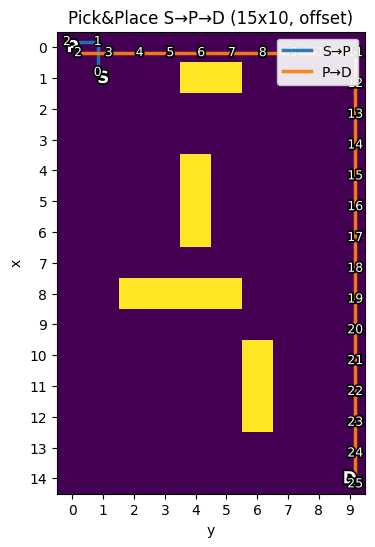

Saved GIF to: pickplace_15x10_offset.gif


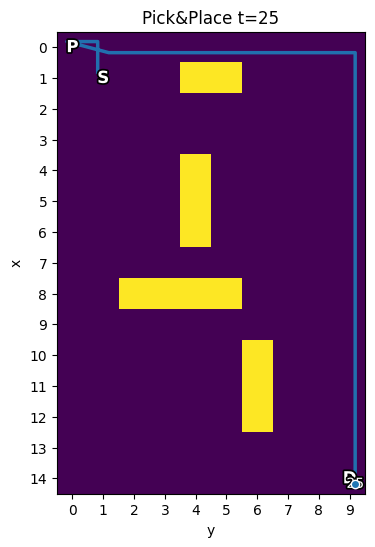

In [25]:
# ==========================================
# Run end-to-end on your 15x10 pick&place RDDL
# ==========================================
# Files you already set:
# NEW_FILES = {
#   "domain":   "warehouse_pickplace_domain.rddl",
#   "nonfl":    "warehouse_pickplace_nonfluents_15x10.rddl",
#   "instance": "warehouse_pickplace_instance_15x10.rddl",
# }
nf_text = read_text(NEW_FILES["nonfl"])
ins_text = read_text(NEW_FILES["instance"])

# parse structures (reuse your summarize_file results if already loaded as nf2/ins2)
kind_nf, nf2 = summarize_file(NEW_FILES["nonfl"])
kind_in, ins2 = summarize_file(NEW_FILES["instance"])

# 1) infer start
start_xy = parse_start_from_instance_text(ins_text) or ins2.get("init_agent_xy")
start_xy = validate_or_fallback(nf2, start_xy)

# 2) infer pick/drop sets
pick_set, drop_set = parse_pick_drop_from_nonfluent_text(nf_text)
if not pick_set:
    print("[WARN] No pick locations found. Fallback to first free cell.")
    pick_set = [first_free_cell_from_grid(nf2)]
if not drop_set:
    print("[WARN] No drop locations found. Fallback to last free cell.")
    # crude fallback: last free cell
    free = free_cells(nf2)
    drop_set = [free[-1] if free else start_xy]

pick_xy, drop_xy = pick_set[0], drop_set[0]
# sanity
pick_xy = validate_or_fallback(nf2, pick_xy)
drop_xy = validate_or_fallback(nf2, drop_xy)

print(f"[Pick&Place] start={start_xy}, pick={pick_xy}, drop={drop_xy}")

# 3) plan two phases
p1, p2 = plan_pick_and_drop(nf2, start_xy, pick_xy, drop_xy)
print("Phase-1 length (S→P):", None if p1 is None else len(p1)-1)
print("Phase-2 length (P→D):", None if p2 is None else len(p2)-1)

# 4) plots
plot_pickdrop_offset(
    nf2, p1, p2,
    start_xy=start_xy, pick_xy=pick_xy, drop_xy=drop_xy,
    title="Pick&Place S→P→D (15x10, offset)"
)

# 5) gif
animate_pickdrop_gif_offset(
    nf2, p1, p2,
    start_xy=start_xy, pick_xy=pick_xy, drop_xy=drop_xy,
    out_gif="pickplace_15x10_offset.gif",
    fps=2
)


In [26]:
import heapq, math
import numpy as np
from typing import Tuple, List, Dict, Optional

def manhattan(a: Tuple[int,int], b: Tuple[int,int]) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def in_bounds(H, W, x, y):
    return 0 <= x < H and 0 <= y < W

def is_free(grid, x, y):
    return grid[x][y] == 0

def neighbors4(grid, x, y):
    H, W = len(grid), len(grid[0])
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = x+dx, y+dy
        if in_bounds(H,W,nx,ny) and is_free(grid,nx,ny):
            yield nx, ny

def reconstruct_path(came_from: Dict[Tuple[int,int], Tuple[int,int]],
                     goal: Tuple[int,int]) -> List[Tuple[int,int]]:
    if goal not in came_from:
        return None
    path = [goal]
    cur = goal
    while came_from[cur] is not None:
        cur = came_from[cur]
        path.append(cur)
    path.reverse()
    return path

def astar_with_footprint(grid: List[List[int]],
                         start: Tuple[int,int],
                         goal: Tuple[int,int],
                         heuristic="manhattan"):
    """A* that records footprints: closed/explored order, g/h/f arrays, open touches."""
    H, W = len(grid), len(grid[0])
    h_func = manhattan if heuristic == "manhattan" else manhattan  # reserve switch

    # init arrays
    g = np.full((H,W), np.inf, dtype=float)
    h = np.zeros((H,W), dtype=float)
    f = np.full((H,W), np.inf, dtype=float)
    came_from: Dict[Tuple[int,int], Optional[Tuple[int,int]]] = {}

    # footprints
    closed_order: Dict[Tuple[int,int], int] = {}  # pop sequence index
    open_touched: set = set()                     # nodes that ever entered open

    t = 0
    g[start] = 0.0
    h[start] = h_func(start, goal)
    f[start] = h[start]
    came_from[start] = None

    open_heap = [(f[start], t, start)]
    open_set = {start}
    open_touched.add(start)

    while open_heap:
        _, _, u = heapq.heappop(open_heap)
        if u not in open_set:
            continue
        open_set.remove(u)

        # mark closed/explored order
        closed_order[u] = len(closed_order)

        if u == goal:
            return reconstruct_path(came_from, goal), {
                "closed_order": closed_order,
                "g": g, "h": h, "f": f,
                "came_from": came_from,
                "open_touched": open_touched
            }

        ux, uy = u
        for vx, vy in neighbors4(grid, ux, uy):
            alt = g[ux,uy] + 1.0
            if alt < g[vx,vy]:
                g[vx,vy] = alt
                h[vx,vy] = h_func((vx,vy), goal)
                f[vx,vy] = alt + h[vx,vy]
                came_from[(vx,vy)] = u
                t += 1
                heapq.heappush(open_heap, (f[vx,vy], t, (vx,vy)))
                open_set.add((vx,vy))
                open_touched.add((vx,vy))

    return None, {
        "closed_order": closed_order,
        "g": g, "h": h, "f": f,
        "came_from": came_from,
        "open_touched": open_touched
    }


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from typing import Sequence, Tuple, Optional, List

def quad_bezier(P0, P1, P2, n=12):
    """Quadratic Bezier between P0->P2 with control P1; returns (xs, ys)."""
    t = np.linspace(0, 1, n, dtype=float)
    Bx = (1-t)**2*P0[0] + 2*(1-t)*t*P1[0] + t**2*P2[0]
    By = (1-t)**2*P0[1] + 2*(1-t)*t*P1[1] + t**2*P2[1]
    return Bx, By

def smooth_polyline_bezier(points: Sequence[Tuple[float,float]],
                           samples_per_seg: int = 12,
                           normal_amp: float = 0.25):
    """
    Make a smooth curve through a grid polyline using per-segment quadratic Bezier.
    Control point = segment midpoint displaced along a perpendicular "normal".
    """
    if points is None or len(points) < 2:
        return None
    xs_s, ys_s = [], []
    for i in range(len(points)-1):
        x0,y0 = points[i]
        x2,y2 = points[i+1]
        # segment direction
        vx, vy = x2-x0, y2-y0
        # perpendicular normal (vy, -vx)
        nx, ny = float(vy), float(-vx)
        nlen = math.hypot(nx, ny) or 1.0
        nx, ny = nx/nlen, ny/nlen
        # control point near midpoint with small normal displacement
        xm, ym = (x0+x2)/2.0, (y0+y2)/2.0
        P1 = (xm + normal_amp*nx, ym + normal_amp*ny)
        bx, by = quad_bezier((x0,y0), P1, (x2,y2), n=samples_per_seg)
        if i > 0:
            bx, by = bx[1:], by[1:]  # avoid duplicating vertex
        xs_s.extend(bx.tolist())
        ys_s.extend(by.tolist())
    return np.array(xs_s), np.array(ys_s)

def _wtxt(ax, y, x, s, **kw):
    kw.setdefault("fontsize", 10)
    kw.setdefault("color", "white")
    kw.setdefault("ha", "center")
    kw.setdefault("va", "center")
    t = ax.text(y, x, s, **kw)
    t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="black")])
    return t

def plot_pickdrop_offset_smooth(
    nonfl: dict,
    p1: Optional[List[Tuple[int,int]]],   # S→P
    p2: Optional[List[Tuple[int,int]]],   # P→D
    start_xy: Tuple[int,int],
    pick_xy: Tuple[int,int],
    drop_xy: Tuple[int,int],
    k_step: int = 5,                      # 仅每 k 步标注一次（外加首尾）
    off_p1: Tuple[float,float] = (-0.18, -0.18),
    off_p2: Tuple[float,float] = ( 0.18,  0.18),
    ls1: str = "--", ls2: str = "-",
    use_bezier: bool = True,
    bezier_amp: float = 0.22,
    samples_per_seg: int = 14,
    title: str = "Pick&Place (smooth & offset)"
):
    H, W = nonfl["H"], nonfl["W"]
    grid = build_grid(nonfl)

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.imshow(grid)
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

    # anchors
    for lab, (x,y) in [("S", start_xy), ("P", pick_xy), ("D", drop_xy)]:
        _wtxt(ax, y, x, lab, fontsize=12, fontweight="bold")

    def draw_phase(path, offset, ls, phase_name, color=None, base_t=0):
        if not path or len(path) < 2:
            return base_t
        dx, dy = offset
        pts = [(x+dx, y+dy) for (x,y) in path]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        if use_bezier:
            sx, sy = smooth_polyline_bezier(pts, samples_per_seg=samples_per_seg, normal_amp=bezier_amp)
            ax.plot(sy, sx, ls, linewidth=2.6, alpha=0.95, label=phase_name)
        else:
            ax.plot(ys, xs, ls, linewidth=2.6, alpha=0.95, label=phase_name)

        # sparse time labels: first / every k-step / last
        T = len(path)-1
        def need(t):
            return t in (0, T) or (t % k_step == 0)
        for t,(x,y) in enumerate(path):
            if need(t):
                _wtxt(ax, y+dy, x+dx, f"{base_t+t}", fontsize=9)
        return base_t + T

    base = 0
    base = draw_phase(p1, off_p1, ls1, "S→P", base_t=base)
    base = draw_phase(p2, off_p2, ls2, "P→D", base_t=base)

    ax.legend(loc="upper right", framealpha=0.9)
    plt.show()


In [34]:
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import numpy as np
import matplotlib.patheffects as pe
import math

def animate_pickdrop_smooth_gif(
    nonfl: dict,
    p1,                 # S -> P path
    p2,                 # P -> D path
    start_xy,
    pick_xy,
    drop_xy,
    out_gif="pickplace_smooth.gif",
    fps=2,
    k_step=5,
    off_p1=(-0.18, -0.18),
    off_p2=( 0.18,  0.18),
    ls1="--",
    ls2="-",
    use_bezier=True,
    bezier_amp=0.22,
    samples_per_seg=14,
):
    """
    Generate a GIF for pick→place showing both path segments
    (smooth Bezier offset + sparse time labels).
    """

    grid = build_grid(nonfl)
    H, W = nonfl["H"], nonfl["W"]

    # small text helper
    def _wtxt(ax, y, x, s, **kw):
        kw.setdefault("fontsize", 10)
        kw.setdefault("color", "white")
        kw.setdefault("ha", "center")
        kw.setdefault("va", "center")
        t = ax.text(y, x, s, **kw)
        t.set_path_effects([pe.withStroke(linewidth=2.0, foreground="black")])
        return t

    # reuse your bezier helper
    def quad_bezier(P0, P1, P2, n=12):
        t = np.linspace(0, 1, n, dtype=float)
        Bx = (1-t)**2*P0[0] + 2*(1-t)*t*P1[0] + t**2*P2[0]
        By = (1-t)**2*P0[1] + 2*(1-t)*t*P1[1] + t**2*P2[1]
        return Bx, By

    def smooth_polyline_bezier(points, samples_per_seg=12, normal_amp=0.25):
        if points is None or len(points) < 2:
            return None
        xs_s, ys_s = [], []
        for i in range(len(points)-1):
            x0,y0 = points[i]
            x2,y2 = points[i+1]
            # segment direction
            vx, vy = x2-x0, y2-y0
            nx, ny = float(vy), float(-vx)
            nlen = math.hypot(nx, ny) or 1.0
            nx, ny = nx/nlen, ny/nlen
            xm, ym = (x0+x2)/2.0, (y0+y2)/2.0
            P1 = (xm + normal_amp*nx, ym + normal_amp*ny)
            bx, by = quad_bezier((x0,y0), P1, (x2,y2), n=samples_per_seg)
            if i>0:
                bx,by = bx[1:],by[1:]
            xs_s.extend(bx.tolist())
            ys_s.extend(by.tolist())
        return np.array(xs_s), np.array(ys_s)

    # build combined time sequence → each element (phase, (x,y))
    seq = []
    if p1:
        seq += [("p1", pt) for pt in p1]
    if p2:
        # avoid duplicating pivot (pick_xy)
        seq += [("p2", pt) for pt in p2[1:]]
    T = len(seq) - 1
    T = max(T, 0)

    # build partial XY for final smooth draw
    def offset_path(path, off):
        dx, dy = off
        return [(x+dx, y+dy) for (x,y) in path]

    pts1 = offset_path(p1, off_p1) if p1 else []
    pts2 = offset_path(p2, off_p2) if p2 else []

    # pre-smooth curves
    if use_bezier:
        curve1 = smooth_polyline_bezier(pts1, samples_per_seg=samples_per_seg, normal_amp=bezier_amp)
        curve2 = smooth_polyline_bezier(pts2, samples_per_seg=samples_per_seg, normal_amp=bezier_amp)
    else:
        curve1 = (np.array([p[0] for p in pts1]), np.array([p[1] for p in pts1]))
        curve2 = (np.array([p[0] for p in pts2]), np.array([p[1] for p in pts2]))

    # each frame = up to t
    fig, ax = plt.subplots(figsize=(6.5,6.5))
    writer = PillowWriter(fps=fps)

    with writer.saving(fig, out_gif, dpi=120):
        for t_i in range(T+1):
            ax.clear()
            ax.imshow(grid)
            ax.set_title(f"Pick→Deliver   t={t_i}")
            ax.set_xticks(range(W)); ax.set_yticks(range(H))
            ax.set_xlabel("y"); ax.set_ylabel("x")
            ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)

            # anchors
            for lab,(x,y) in [("S",start_xy),("P",pick_xy),("D",drop_xy)]:
                _wtxt(ax, y, x, lab, fontsize=12, fontweight="bold")

            # draw partial
            # S→P
            if curve1 is not None:
                cx, cy = curve1
                # restrict draw until S→P is done
                if p1:
                    end_t1 = (len(p1)-1)
                    # approximate ratio
                    ratio = min(1.0, t_i/max(1,end_t1))
                    cut = int(ratio * len(cx))
                    ax.plot(cy[:cut], cx[:cut], ls1, color="deepskyblue", linewidth=2.8, alpha=0.95)

            # P→D
            if curve2 is not None:
                # frames after pivot
                if p2 and t_i >= (len(p1)-1):
                    # how far into p2?
                    remain = t_i - (len(p1)-1)
                    end_t2 = (len(p2)-1)
                    ratio2 = min(1.0, remain/max(1,end_t2))
                    c2x, c2y = curve2
                    cut2 = int(ratio2 * len(c2x))
                    ax.plot(c2y[:cut2], c2x[:cut2], ls2, color="tomato", linewidth=2.8, alpha=0.95)

            # text sparse
            # base offset
            base = 0
            def need(idx,T):
                return idx in (0,T) or (idx % k_step == 0)

            # S→P labels
            if p1:
                T1 = len(p1)-1
                for i,(x,y) in enumerate(p1):
                    if need(i, T1) and i<=t_i:
                        _wtxt(ax, y+off_p1[1], x+off_p1[0], f"{i}", fontsize=9)
                base = T1

            # P→D labels
            if p2:
                T2 = len(p2)-1
                for i,(x,y) in enumerate(p2):
                    glob_i = base + i
                    # pivot index skip (i==0 is same location)
                    if need(glob_i, T1+T2) and glob_i<=t_i:
                        _wtxt(ax, y+off_p2[1], x+off_p2[0], f"{glob_i}", fontsize=9)

            writer.grab_frame()

    print(f"[OK] saved GIF → {out_gif}")


In [28]:
def plot_explored_heatmap(nonfl: dict, footprint: dict, title="A* explored (closed order)"):
    H, W = nonfl["H"], nonfl["W"]
    grid = build_grid(nonfl)
    order = np.full((H,W), np.nan, dtype=float)
    for (x,y), idx in footprint["closed_order"].items():
        order[x,y] = idx

    fig, ax = plt.subplots(figsize=(6.5,6.5))
    ax.imshow(grid, alpha=0.35)  # obstacles overlay
    im = ax.imshow(order, cmap="magma", alpha=0.9)
    ax.set_title(title)
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Closed/set pop order")
    plt.show()

def plot_heuristic_field(nonfl: dict, footprint: dict, field="h"):
    """field in {'h','g','f'}"""
    H, W = nonfl["H"], nonfl["W"]
    grid = build_grid(nonfl)
    arr = footprint[field].copy()
    arr[arr==np.inf] = np.nan
    fig, ax = plt.subplots(figsize=(6.5,6.5))
    ax.imshow(grid, alpha=0.35)
    im = ax.imshow(arr, cmap="viridis", alpha=0.9)
    ax.set_title(f"{field.upper()} field")
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.set_xlabel("y"); ax.set_ylabel("x")
    ax.set_xlim(-0.5, W-0.5); ax.set_ylim(H-0.5, -0.5)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(field.upper())
    plt.show()


Phase-1 (S→P) length: 2
Phase-2 (P→D) length: 23


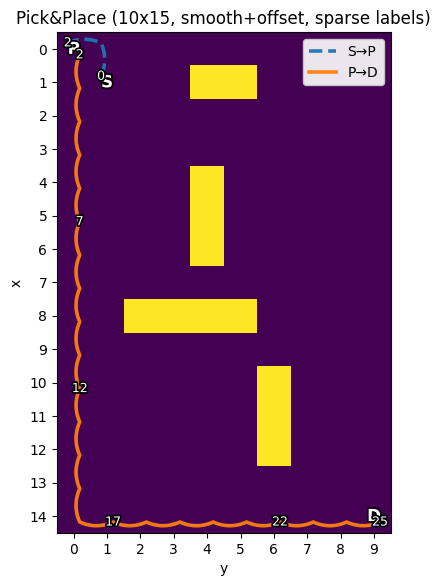

In [33]:
# 1) build grid
grid = build_grid(nf2)

# 2) A* with footprints on both phases
p1, fp1 = astar_with_footprint(grid, start_xy, pick_xy, heuristic="manhattan")
p2, fp2 = astar_with_footprint(grid, pick_xy, drop_xy, heuristic="manhattan")

print("Phase-1 (S→P) length:", None if p1 is None else len(p1)-1)
print("Phase-2 (P→D) length:", None if p2 is None else len(p2)-1)

# 3) Smooth & offset plot with distinct linestyles and sparse labels
plot_pickdrop_offset_smooth(
    nonfl=nf2,
    p1=p1, p2=p2,
    start_xy=start_xy, pick_xy=pick_xy, drop_xy=drop_xy,
    k_step=5,                 # 仅每 5 步打一次时间戳
    off_p1=(-0.18,-0.18),     # S→P 细微错位
    off_p2=( 0.18, 0.18),     # P→D 细微错位
    ls1="--", ls2="-",        # 不同线型强调任务切换
    use_bezier=True,          # 使用 Bezier 平滑
    bezier_amp=0.22,          # 平滑曲线弯曲强度
    samples_per_seg=14,
    title="Pick&Place (10x15, smooth+offset, sparse labels)"
)

[OK] saved GIF → pickplace_10x15_smooth.gif


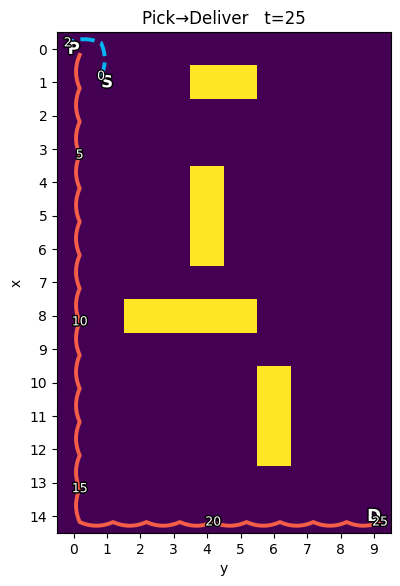

In [35]:
animate_pickdrop_smooth_gif(
    nonfl=nf2,
    p1=p1, p2=p2,
    start_xy=start_xy, pick_xy=pick_xy, drop_xy=drop_xy,
    out_gif="pickplace_10x15_smooth.gif",
    fps=2,
    k_step=5,
    off_p1=(-0.18,-0.18),
    off_p2=( 0.18, 0.18),
    ls1="--",
    ls2="-",
    use_bezier=True,
    bezier_amp=0.22,
    samples_per_seg=14
)


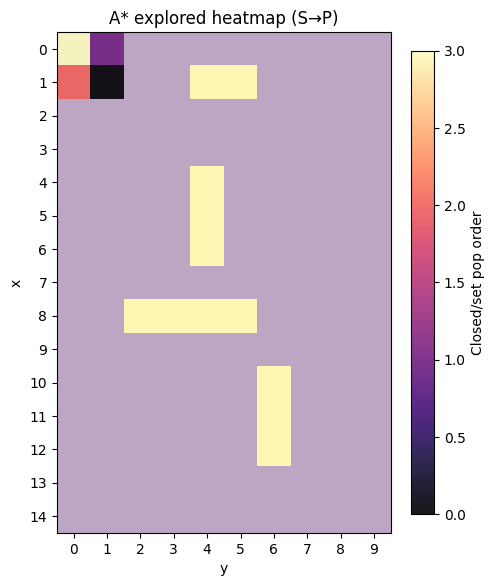

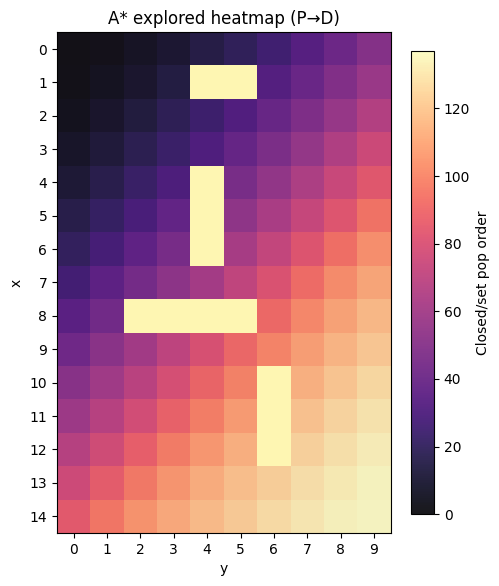

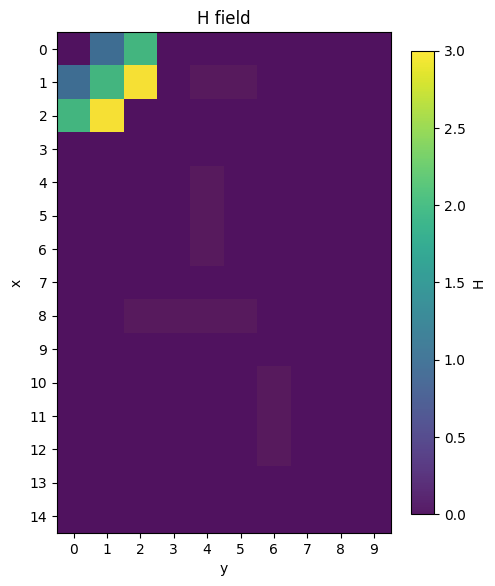

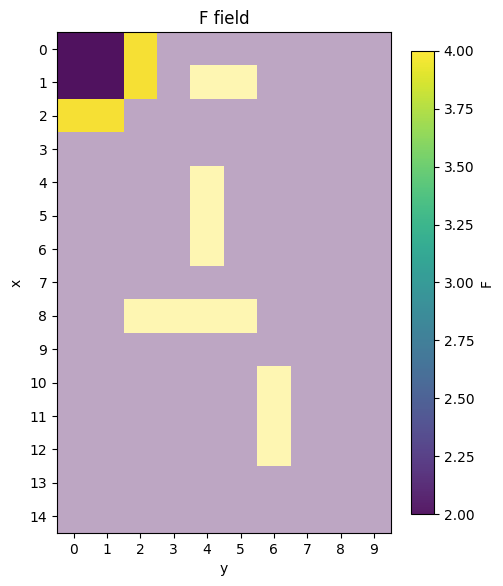

In [31]:
# 4) Footprints 可视化（探索热力图 + h/f）
plot_explored_heatmap(nf2, fp1, title="A* explored heatmap (S→P)")
plot_explored_heatmap(nf2, fp2, title="A* explored heatmap (P→D)")
plot_heuristic_field(nf2, fp1, field="h")
plot_heuristic_field(nf2, fp1, field="f")
